# PS reconstruction, Gaussian beam

In [1]:
import torch
from copy import deepcopy

import lightning as L

from gpsr.diagnostics import ImageDiagnostic
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Import data

torch.Size([2, 2, 5, 3]) torch.Size([2, 5, 200, 200]) torch.Size([2, 5, 200, 200])


/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


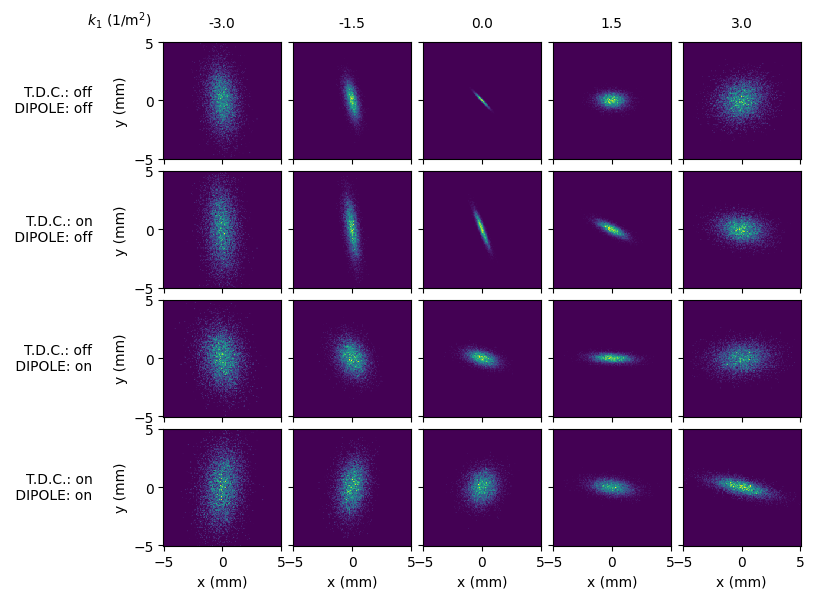

In [2]:
obs_dataset = torch.load("example_data/example_datasets/reconstruction_6D.dset", weights_only=False)

print(
    obs_dataset.parameters.shape,
    obs_dataset.observations[0].shape,
    obs_dataset.observations[1].shape,
)

obs_dataset.plot_data(publication_size=True);

## Set up diagnostic lattice in cheetah
These parameters match those at the Argonne Wakefield Accelerator (AWA) and were used
 to generate the synthetic example dataset.

In [3]:
p0c = 43.36e6  # reference momentum in eV/c

bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1] - bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
)

## Training using pytorch lightning

In [4]:
obs_dataset.parameters.shape

torch.Size([2, 2, 5, 3])

In [5]:
obs_dataset.observations[0].shape

torch.Size([2, 5, 200, 200])

In [6]:
full_batch_size = obs_dataset.observations[0].shape[0]*obs_dataset.observations[0].shape[1]
print(f'Full batch size: {full_batch_size}')

Full batch size: 10


In [7]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=full_batch_size, shuffle=False)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging int

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s, v_num=33]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, v_num=33]


In [8]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

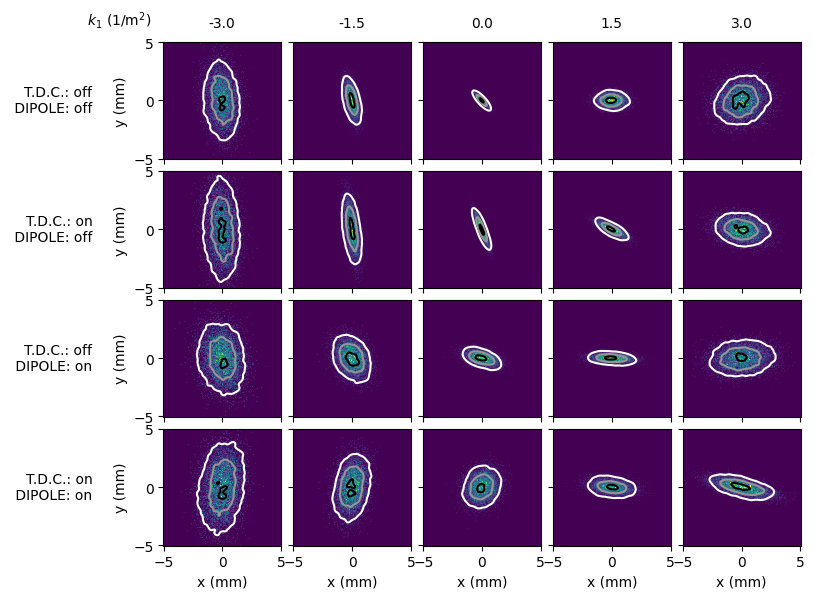

In [9]:
train_params = obs_dataset.parameters
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, (bins, bins))
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap": "Greys", "levels": [0.1, 0.5, 0.9]},
);

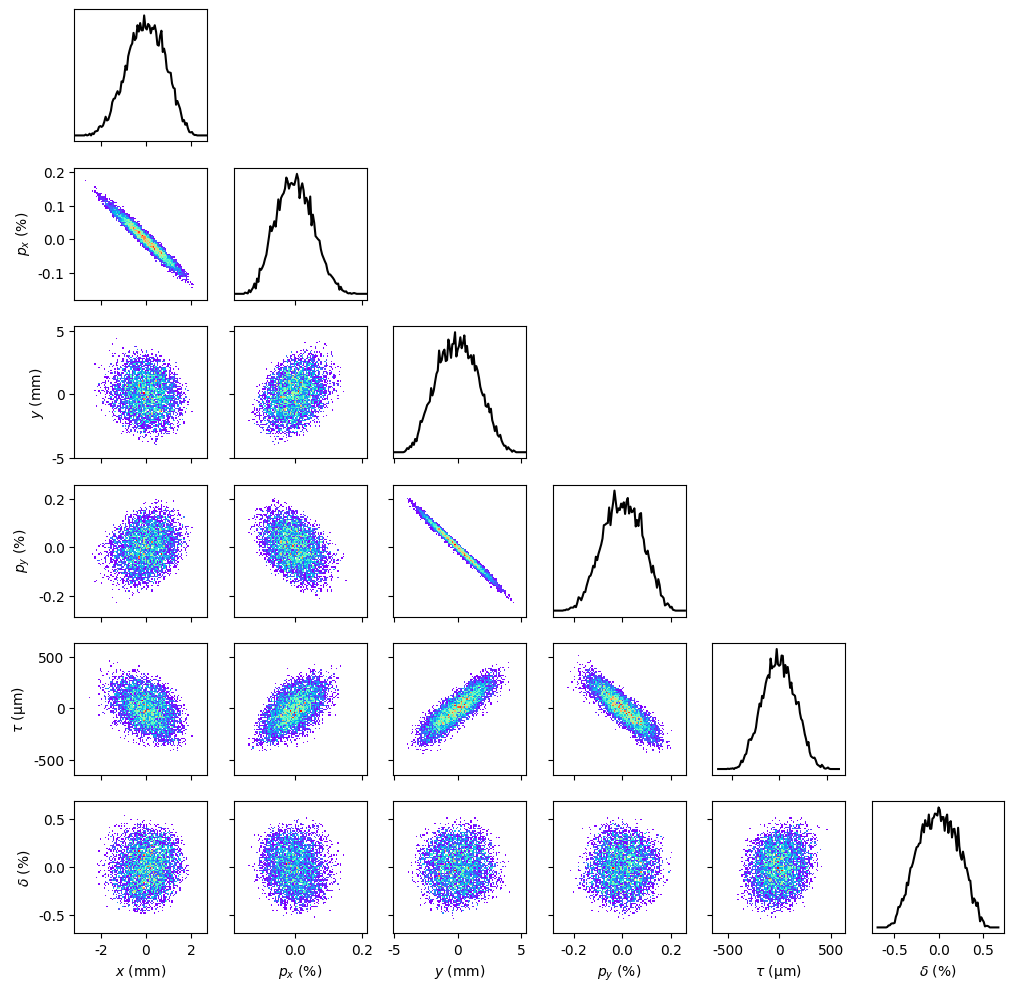

In [10]:
reconstructed_beam.plot_distribution();